# Homework 4 (Ibotta Products)

In [1]:
# import analysis packages
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Embedding, Flatten, SimpleRNN, TextVectorization
from keras.models import Sequential
from keras.regularizers import l2
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

/Users/akiehl/miniconda3/envs/dsci/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/akiehl/miniconda3/envs/dsci/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fil

### Data Preprocessing

In [2]:
# read data from .csv files
trainDF = pd.read_csv('./ibotta_train.csv')
testDF = pd.read_csv('./ibotta_test.csv')

In [3]:
# combine data sets for preprocessing
trainDF['origin'] = 'train'
testDF['origin'] = 'test'
fullDF = pd.concat([trainDF, testDF])

# seed random seed
random.seed(542023)

# split data
trainDF = pd.DataFrame(fullDF.loc[fullDF['origin'] == 'train'].drop('origin', axis = 1))
validIdx = random.sample(list(trainDF['Id'] - 1), 1000)
validDF = trainDF.loc[validIdx]
trainDF = trainDF.loc[trainDF['Id'].apply(lambda x: x not in validIdx)]
testDF = pd.DataFrame(fullDF.loc[fullDF['origin'] == 'test'].drop(['origin', 'Category'], axis = 1))

In [4]:
# check dimensions of data
display(trainDF.shape)
display(validDF.shape)
display(testDF.shape)

# check data types
display(trainDF.info())

# peek at data
display(trainDF.head())

(7000, 5)

(1000, 5)

(1999, 4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          7000 non-null   int64  
 1   Name        7000 non-null   object 
 2   Brand_name  5702 non-null   object 
 3   Category    7000 non-null   object 
 4   Cat_code    7000 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 328.1+ KB


None

,Id,Name,Brand_name,Category,Cat_code
0,1,"4C HomeStyle Parmesan Grated Cheese, 6 oz",4C,Dairy,2.0
1,2,"4C 100% Natural Parmesan Cheese, 6 oz",NaN,Dairy,2.0
2,3,"4C Parmesan & Romano Cheese, Grated",4C,Dairy,2.0
3,4,Advance Fast Fixin' Country Fried Steaks with ...,Fast Fixin',Frozen Foods,3.0
5,6,"Borden Natural Medium Cheddar Cheese, 8 oz",Borden Dairy Company,Dairy,2.0


### Text Vectorization

In [5]:
# train integer index tokenizer
intTokenizer = TextVectorization()
intTokenizer.adapt(fullDF['Name'])

# vectorize text data
intVecDF = pd.DataFrame(intTokenizer(fullDF['Name']))
trainDFintVec = intVecDF.loc[0:7999]
trainDFintVec = trainDFintVec.loc[pd.Series(trainDFintVec.index).apply(lambda x: x not in validIdx)]
validDFintVec = intVecDF.loc[validIdx]
testDFintVec = intVecDF.loc[8000:9999]

# data shape and form
display(trainDFintVec.shape)
display(validDFintVec.shape)
display(testDFintVec.shape)
display(trainDFintVec.head())

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-05-09 19:20:33.870625: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(7000, 48)

(1000, 48)

(1999, 48)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,1941,397,141,575,2,100,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1941,137,35,141,2,100,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1941,141,842,2,575,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4442,1529,3877,143,209,786,27,758,0,0,...,0,0,0,0,0,0,0,0,0,0
4,589,116,95,129,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# train bag of words tokenizer
countTokenizer = TextVectorization(output_mode = 'count')
countTokenizer.adapt(fullDF['Name'])

# vectorize text data
countVecDF = pd.DataFrame(countTokenizer(fullDF['Name']))
trainDFcountVec = countVecDF.loc[0:7999]
trainDFcountVec = trainDFcountVec.loc[pd.Series(trainDFcountVec.index).apply(lambda x: x not in validIdx)]
validDFcountVec = countVecDF.loc[validIdx]
testDFcountVec = countVecDF.loc[8000:9999]

# data shape and form
display(trainDFcountVec.shape)
display(validDFcountVec.shape)
display(testDFcountVec.shape)
display(trainDFcountVec.head())

(7000, 4723)

(1000, 4723)

(1999, 4723)

,0,1,2,3,4,5,6,7,8,9,...,4713,4714,4715,4716,4717,4718,4719,4720,4721,4722
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# train bag of words tokenizer
tfidfTokenizer = TextVectorization(output_mode = 'tf_idf')
tfidfTokenizer.adapt(fullDF['Name'])

# vectorize text data
tfidfVecDF = pd.DataFrame(tfidfTokenizer(fullDF['Name']))
trainDFtfidfVec = tfidfVecDF.loc[0:7999]
trainDFtfidfVec = trainDFtfidfVec.loc[pd.Series(trainDFtfidfVec.index).apply(lambda x: x not in validIdx)]
validDFtfidfVec = tfidfVecDF.loc[validIdx]
testDFtfidfVec = tfidfVecDF.loc[8000:9999]

# data shape and form
display(trainDFtfidfVec.shape)
display(validDFtfidfVec.shape)
display(testDFtfidfVec.shape)
display(trainDFtfidfVec.head())

(7000, 4723)

(1000, 4723)

(1999, 4723)

,0,1,2,3,4,5,6,7,8,9,...,4713,4714,4715,4716,4717,4718,4719,4720,4721,4722
0,0.0,2.185138,2.183039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.185138,2.183039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.185138,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Fitting

In [8]:
# model evaluation function
def EvaluateModel(model, X_train):
    # set random seeds
    np.random.seed(542023)
    tf.random.set_seed(542023)

    # print model summary
    try:
        model.summary()
    except:
        pass

    # define F1 metric
    f1_score_metric = F1Score(num_classes = 7, average = 'weighted')

    # compile model
    model.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy', f1_score_metric])
    
    # define early stopping criterion
    early = EarlyStopping(monitor = 'val_f1_score', mode = 'max', patience = 3)

    # train deep learning model
    trained = model.fit(X_train,
                        to_categorical(trainDF['Cat_code']),
                        epochs = 100,
                        batch_size = 128,
                        callbacks = early,
                        validation_split = 0.15,
                        verbose = 1)
    
    # prepare model evaluation
    acc = trained.history['accuracy']
    val_acc = trained.history['val_accuracy']
    loss = trained.history['loss']
    val_loss = trained.history['val_loss']
    f1_score = trained.history['f1_score']
    val_f1_score = trained.history['val_f1_score']
    epochs = range(1, len(acc) + 1)

    # final validation accuracy
    display(f"Internal validation accuracy: {round(val_acc[-1] * 100, 2)}%")
    display(f'Internal validation F1 score: {round(val_f1_score[-1], 4)}')

    # plot training accuracy
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 5))
    ax1.plot(epochs, acc, 'bo', label = 'Training acc')
    ax1.plot(epochs, val_acc, 'b', label = 'Validation acc')
    ax1.set(xlabel = 'Epochs', ylabel = 'Accuracy')
    ax1.legend()
    ax2.plot(epochs, loss, 'bo', label = 'Training loss')
    ax2.plot(epochs, val_loss, 'b', label = 'Validation loss')
    ax2.set(xlabel = 'Epochs', ylabel = 'Loss')
    ax2.legend()
    ax3.plot(epochs, f1_score, 'bo', label = 'Training F1')
    ax3.plot(epochs, val_f1_score, 'b', label = 'Validation F1')
    ax3.set(xlabel = 'Epochs', ylabel = 'F1 Score')
    ax3.legend()
    fig.suptitle('Evaluation Metrics')

### Basic MLP Models

Epoch 1/100
47/47 [==============================] - 2s 25ms/step - loss: 11.0083 - accuracy: 0.1407 - f1_score: 0.1471 - val_loss: 3.0942 - val_accuracy: 0.1876 - val_f1_score: 0.1612
Epoch 2/100
47/47 [==============================] - 1s 18ms/step - loss: 2.2064 - accuracy: 0.2682 - f1_score: 0.1629 - val_loss: 1.9557 - val_accuracy: 0.2524 - val_f1_score: 0.1222
Epoch 3/100
47/47 [==============================] - 1s 18ms/step - loss: 1.9090 - accuracy: 0.2993 - f1_score: 0.1433 - val_loss: 1.9049 - val_accuracy: 0.2467 - val_f1_score: 0.0976
Epoch 4/100
47/47 [==============================] - 1s 18ms/step - loss: 1.8694 - accuracy: 0.3012 - f1_score: 0.1423 - val_loss: 1.8953 - val_accuracy: 0.2457 - val_f1_score: 0.0974


'Internal validation accuracy: 24.57%'

'Internal validation F1 score: 0.0974'

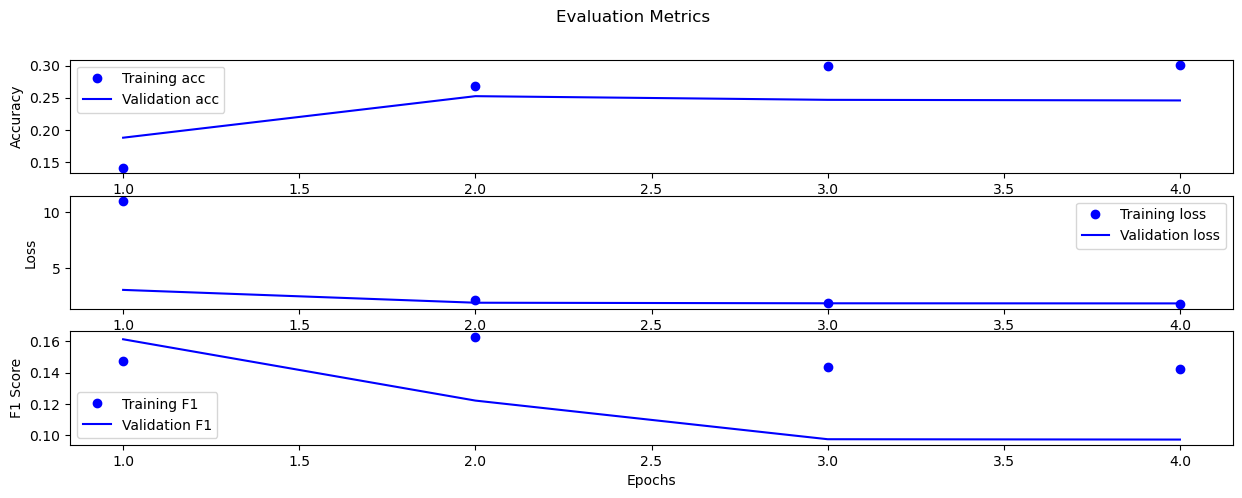

In [9]:
# define model architecture
model = Sequential([
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(8, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Epoch 1/100
54/54 [==============================] - 2s 24ms/step - loss: 14.6316 - accuracy: 0.2028 - f1_score: 0.2090 - val_loss: 8.8445 - val_accuracy: 0.2200 - val_f1_score: 0.1462
Epoch 2/100
54/54 [==============================] - 1s 20ms/step - loss: 3.8737 - accuracy: 0.2354 - f1_score: 0.2303 - val_loss: 3.7892 - val_accuracy: 0.1825 - val_f1_score: 0.1646
Epoch 3/100
54/54 [==============================] - 1s 19ms/step - loss: 2.5093 - accuracy: 0.2593 - f1_score: 0.2407 - val_loss: 2.7507 - val_accuracy: 0.2075 - val_f1_score: 0.1653
Epoch 4/100
54/54 [==============================] - 1s 18ms/step - loss: 2.1344 - accuracy: 0.3001 - f1_score: 0.2637 - val_loss: 2.1815 - val_accuracy: 0.2558 - val_f1_score: 0.1559
Epoch 5/100
54/54 [==============================] - 1s 18ms/step - loss: 2.0150 - accuracy: 0.3107 - f1_score: 0.2631 - val_loss: 1.9487 - val_accuracy: 0.2983 - val_f1_score: 0.2345
Epoch 6/100
54/54 [==============================] - 1s 19ms/step - loss: 1.893

'Internal validation accuracy: 27.5%'

'Internal validation F1 score: 0.1854'

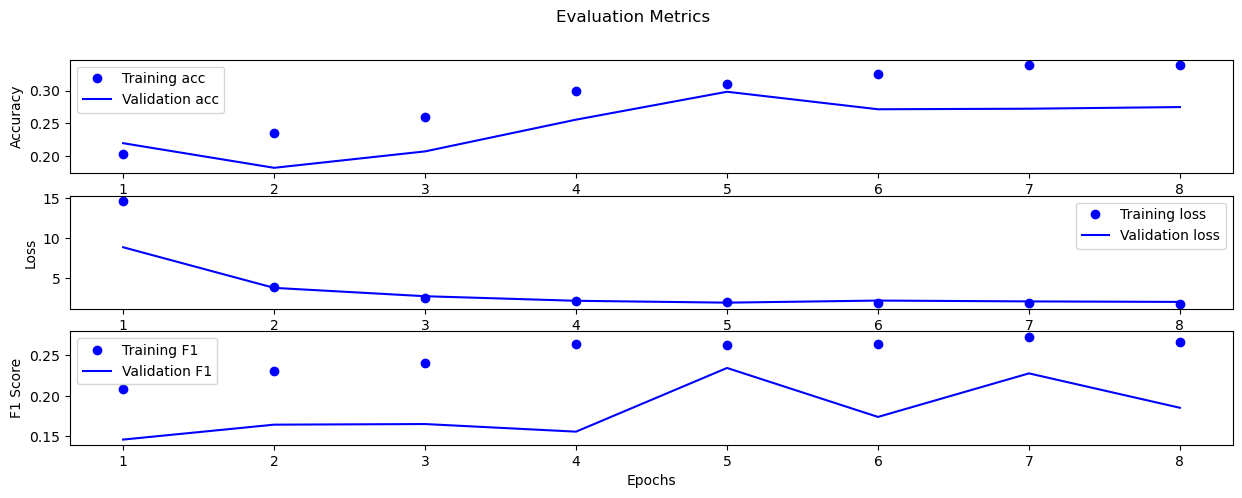

In [8]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Epoch 1/100
47/47 [==============================] - 2s 27ms/step - loss: 1.7897 - accuracy: 0.2933 - f1_score: 0.1590 - val_loss: 1.6259 - val_accuracy: 0.3457 - val_f1_score: 0.2232
Epoch 2/100
47/47 [==============================] - 1s 19ms/step - loss: 1.3481 - accuracy: 0.3699 - f1_score: 0.2373 - val_loss: 1.3375 - val_accuracy: 0.4181 - val_f1_score: 0.3130
Epoch 3/100
47/47 [==============================] - 1s 18ms/step - loss: 1.0103 - accuracy: 0.6118 - f1_score: 0.5781 - val_loss: 1.0586 - val_accuracy: 0.7124 - val_f1_score: 0.7006
Epoch 4/100
47/47 [==============================] - 1s 18ms/step - loss: 0.6355 - accuracy: 0.8635 - f1_score: 0.8486 - val_loss: 0.7870 - val_accuracy: 0.8248 - val_f1_score: 0.8228
Epoch 5/100
47/47 [==============================] - 1s 18ms/step - loss: 0.4219 - accuracy: 0.9180 - f1_score: 0.9175 - val_loss: 0.7207 - val_accuracy: 0.8286 - val_f1_score: 0.8278
Epoch 6/100
47/47 [==============================] - 1s 19ms/step - loss: 0.3374

'Internal validation accuracy: 83.33%'

'Internal validation F1 score: 0.8329'

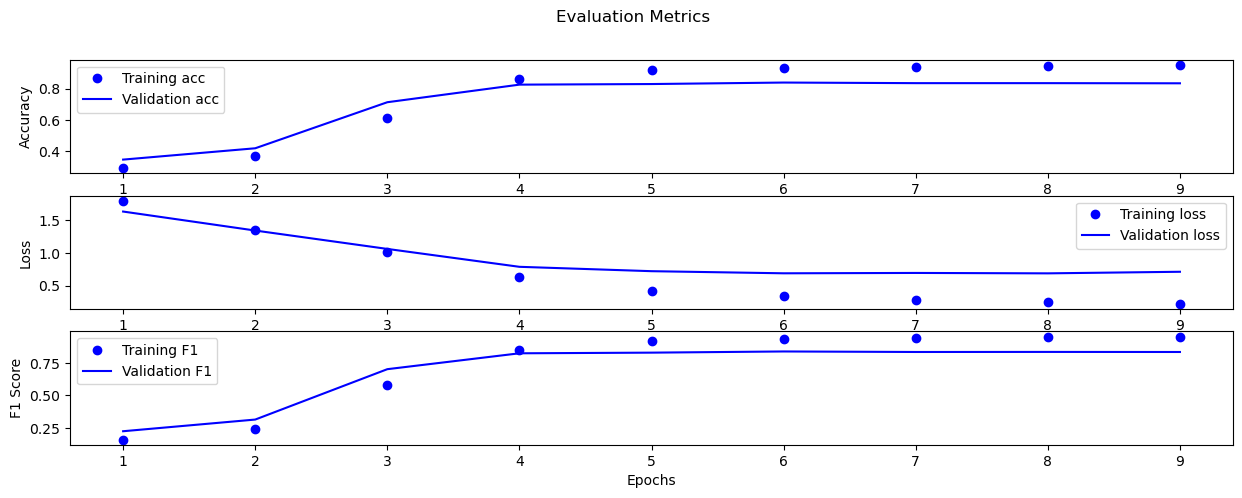

In [10]:
# define model architecture
model = Sequential([
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(8, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Epoch 1/100
54/54 [==============================] - 2s 27ms/step - loss: 0.8222 - accuracy: 0.7163 - f1_score: 0.7107 - val_loss: 0.6307 - val_accuracy: 0.8058 - val_f1_score: 0.7992
Epoch 2/100
54/54 [==============================] - 1s 21ms/step - loss: 0.1466 - accuracy: 0.9588 - f1_score: 0.9589 - val_loss: 0.3944 - val_accuracy: 0.8825 - val_f1_score: 0.8838
Epoch 3/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0681 - accuracy: 0.9799 - f1_score: 0.9799 - val_loss: 0.3179 - val_accuracy: 0.9108 - val_f1_score: 0.9110
Epoch 4/100
54/54 [==============================] - 1s 20ms/step - loss: 0.0428 - accuracy: 0.9868 - f1_score: 0.9868 - val_loss: 0.3803 - val_accuracy: 0.9033 - val_f1_score: 0.9063
Epoch 5/100
54/54 [==============================] - 1s 20ms/step - loss: 0.0299 - accuracy: 0.9912 - f1_score: 0.9912 - val_loss: 0.3953 - val_accuracy: 0.9117 - val_f1_score: 0.9124
Epoch 6/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0244

'Internal validation accuracy: 90.67%'

'Internal validation F1 score: 0.9067'

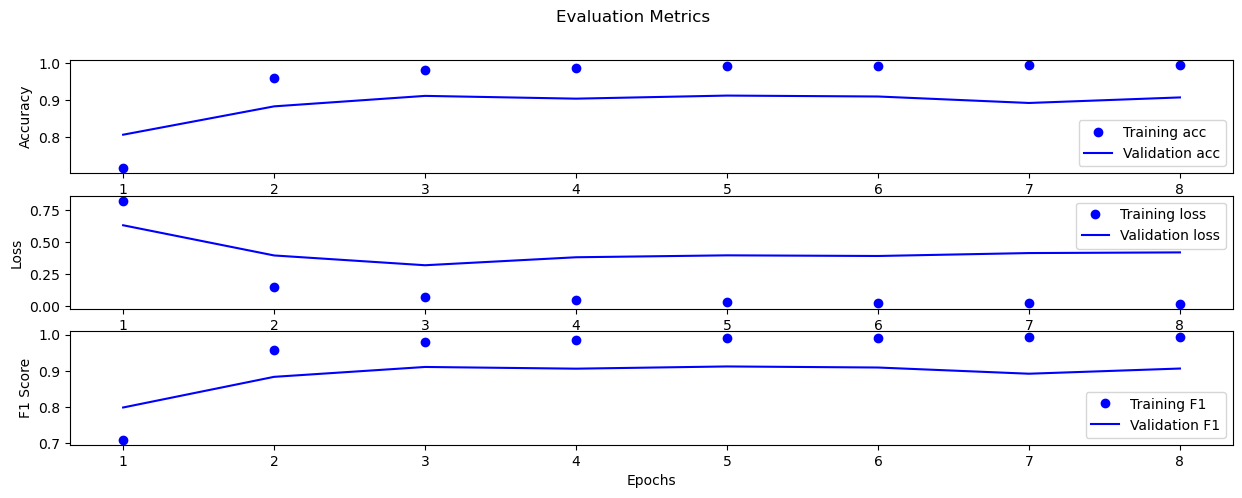

In [9]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Epoch 1/100
47/47 [==============================] - 3s 56ms/step - loss: 1.1021 - accuracy: 0.6096 - f1_score: 0.5872 - val_loss: 0.7326 - val_accuracy: 0.8038 - val_f1_score: 0.8011
Epoch 2/100
47/47 [==============================] - 2s 42ms/step - loss: 0.3720 - accuracy: 0.9163 - f1_score: 0.9162 - val_loss: 0.8018 - val_accuracy: 0.7714 - val_f1_score: 0.7761
Epoch 3/100
47/47 [==============================] - 2s 41ms/step - loss: 0.2426 - accuracy: 0.9444 - f1_score: 0.9443 - val_loss: 0.7517 - val_accuracy: 0.8257 - val_f1_score: 0.8256
Epoch 4/100
47/47 [==============================] - 2s 42ms/step - loss: 0.1768 - accuracy: 0.9583 - f1_score: 0.9583 - val_loss: 0.8153 - val_accuracy: 0.8057 - val_f1_score: 0.8058
Epoch 5/100
47/47 [==============================] - 2s 42ms/step - loss: 0.1308 - accuracy: 0.9671 - f1_score: 0.9670 - val_loss: 0.8515 - val_accuracy: 0.8152 - val_f1_score: 0.8169
Epoch 6/100
47/47 [==============================] - 2s 42ms/step - loss: 0.0909

'Internal validation accuracy: 80.95%'

'Internal validation F1 score: 0.8088'

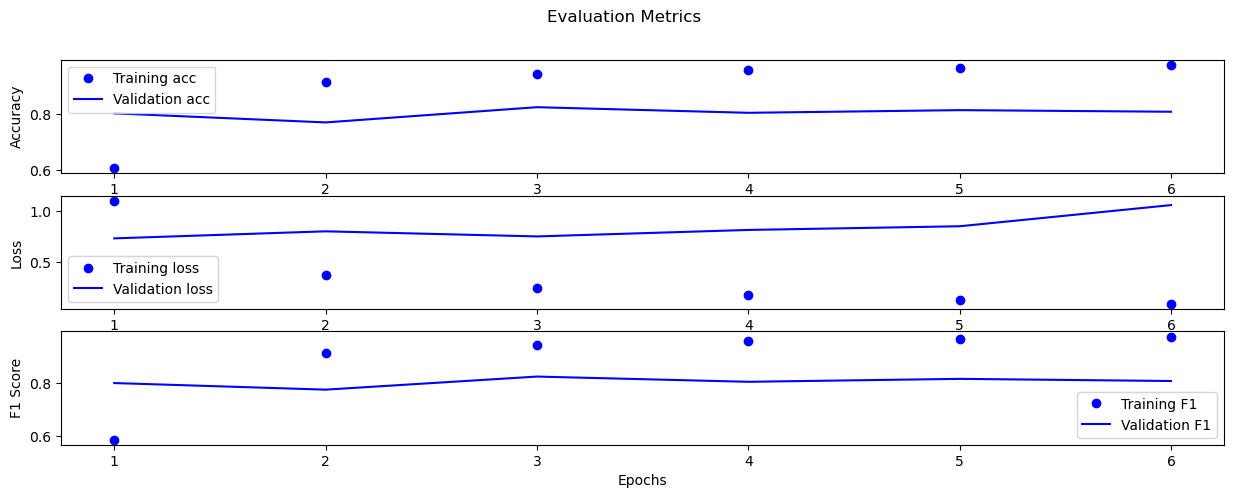

In [30]:
# define model architecture
model = Sequential([
    Dense(2048, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Epoch 1/100
47/47 [==============================] - 4s 63ms/step - loss: 2.6983 - accuracy: 0.4933 - f1_score: 0.4444 - val_loss: 1.5964 - val_accuracy: 0.7067 - val_f1_score: 0.6877
Epoch 2/100
47/47 [==============================] - 2s 47ms/step - loss: 1.1008 - accuracy: 0.8343 - f1_score: 0.8325 - val_loss: 1.1923 - val_accuracy: 0.7743 - val_f1_score: 0.7764
Epoch 3/100
47/47 [==============================] - 2s 51ms/step - loss: 0.8025 - accuracy: 0.8946 - f1_score: 0.8944 - val_loss: 1.0080 - val_accuracy: 0.8162 - val_f1_score: 0.8179
Epoch 4/100
47/47 [==============================] - 2s 48ms/step - loss: 0.7009 - accuracy: 0.9059 - f1_score: 0.9057 - val_loss: 0.9819 - val_accuracy: 0.8000 - val_f1_score: 0.8007
Epoch 5/100
47/47 [==============================] - 2s 49ms/step - loss: 0.6219 - accuracy: 0.9146 - f1_score: 0.9145 - val_loss: 0.9370 - val_accuracy: 0.8143 - val_f1_score: 0.8160
Epoch 6/100
47/47 [==============================] - 2s 50ms/step - loss: 0.5715

'Internal validation accuracy: 80.57%'

'Internal validation F1 score: 0.8058'

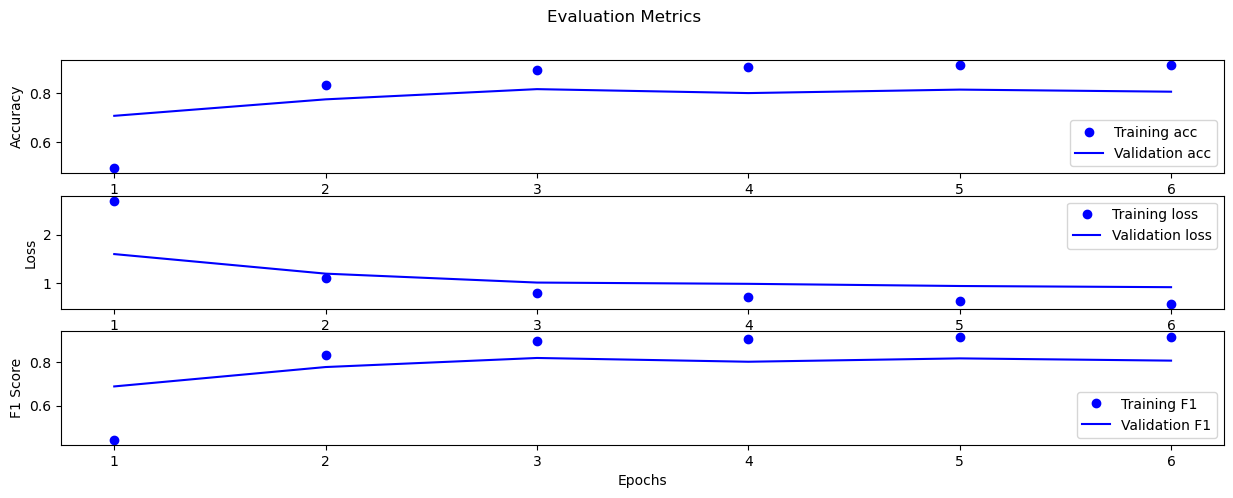

In [29]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Epoch 1/100
47/47 [==============================] - 3s 42ms/step - loss: 1.7015 - accuracy: 0.6336 - f1_score: 0.6180 - val_loss: 1.1850 - val_accuracy: 0.8143 - val_f1_score: 0.8141
Epoch 2/100
47/47 [==============================] - 1s 30ms/step - loss: 0.8293 - accuracy: 0.9029 - f1_score: 0.9028 - val_loss: 1.1452 - val_accuracy: 0.7857 - val_f1_score: 0.7898
Epoch 3/100
47/47 [==============================] - 1s 25ms/step - loss: 0.6804 - accuracy: 0.9213 - f1_score: 0.9212 - val_loss: 0.9208 - val_accuracy: 0.8486 - val_f1_score: 0.8481
Epoch 4/100
47/47 [==============================] - 1s 27ms/step - loss: 0.5896 - accuracy: 0.9306 - f1_score: 0.9305 - val_loss: 0.8853 - val_accuracy: 0.8305 - val_f1_score: 0.8310
Epoch 5/100
47/47 [==============================] - 1s 27ms/step - loss: 0.5438 - accuracy: 0.9323 - f1_score: 0.9321 - val_loss: 0.8984 - val_accuracy: 0.8314 - val_f1_score: 0.8301
Epoch 6/100
47/47 [==============================] - 1s 27ms/step - loss: 0.5056

'Internal validation accuracy: 84.29%'

'Internal validation F1 score: 0.8414'

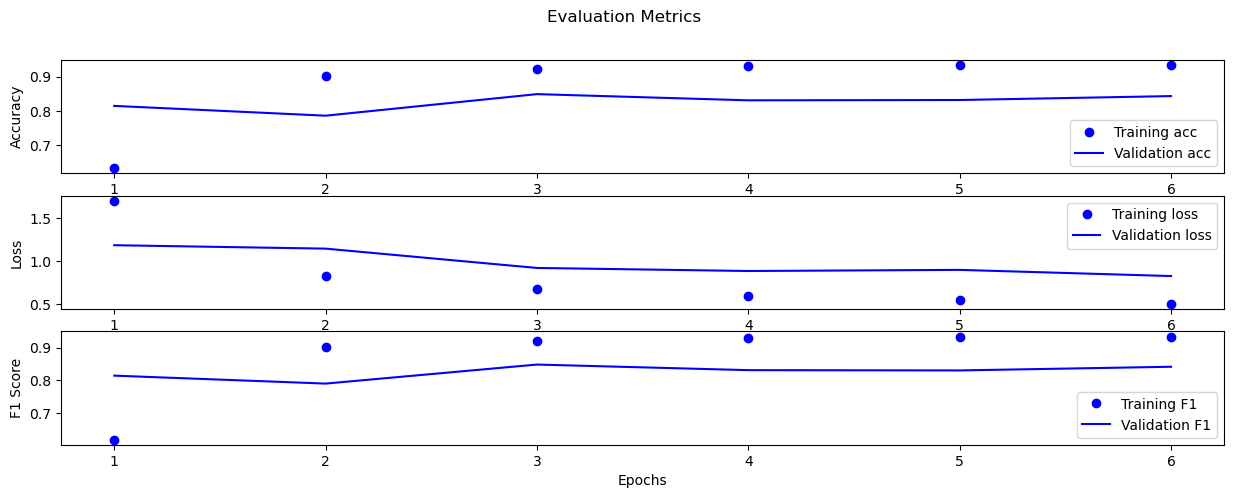

In [33]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Epoch 1/100
54/54 [==============================] - 2s 28ms/step - loss: 0.6815 - accuracy: 0.7713 - f1_score: 0.7685 - val_loss: 0.5254 - val_accuracy: 0.8433 - val_f1_score: 0.8386
Epoch 2/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0934 - accuracy: 0.9740 - f1_score: 0.9740 - val_loss: 0.4710 - val_accuracy: 0.8608 - val_f1_score: 0.8676
Epoch 3/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0379 - accuracy: 0.9884 - f1_score: 0.9884 - val_loss: 0.3861 - val_accuracy: 0.9008 - val_f1_score: 0.9010
Epoch 4/100
54/54 [==============================] - 1s 20ms/step - loss: 0.0280 - accuracy: 0.9913 - f1_score: 0.9913 - val_loss: 0.3740 - val_accuracy: 0.9050 - val_f1_score: 0.9055
Epoch 5/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0201 - accuracy: 0.9931 - f1_score: 0.9931 - val_loss: 0.3975 - val_accuracy: 0.9117 - val_f1_score: 0.9120
Epoch 6/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0156

'Internal validation accuracy: 90.0%'

'Internal validation F1 score: 0.8985'

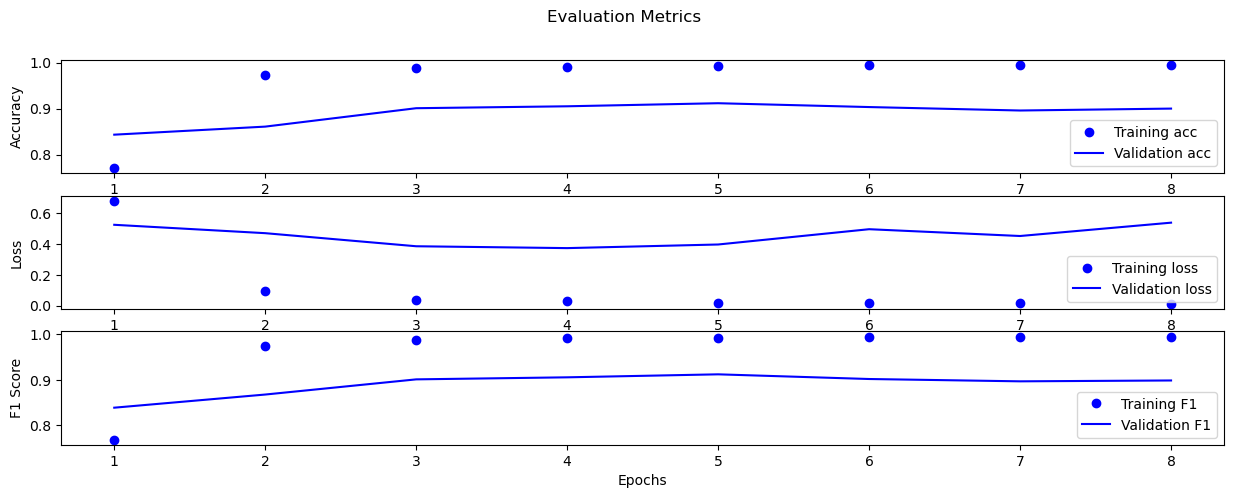

In [10]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec)

Epoch 1/100
47/47 [==============================] - 3s 55ms/step - loss: 1.1956 - accuracy: 0.5766 - f1_score: 0.5549 - val_loss: 0.6765 - val_accuracy: 0.8324 - val_f1_score: 0.8322
Epoch 2/100
47/47 [==============================] - 2s 51ms/step - loss: 0.3553 - accuracy: 0.9203 - f1_score: 0.9202 - val_loss: 0.7745 - val_accuracy: 0.8000 - val_f1_score: 0.8029
Epoch 3/100
47/47 [==============================] - 2s 42ms/step - loss: 0.2153 - accuracy: 0.9496 - f1_score: 0.9495 - val_loss: 0.8655 - val_accuracy: 0.8067 - val_f1_score: 0.8058
Epoch 4/100
47/47 [==============================] - 2s 41ms/step - loss: 0.1556 - accuracy: 0.9637 - f1_score: 0.9637 - val_loss: 0.9682 - val_accuracy: 0.7971 - val_f1_score: 0.7969


'Internal validation accuracy: 79.71%'

'Internal validation F1 score: 0.7969'

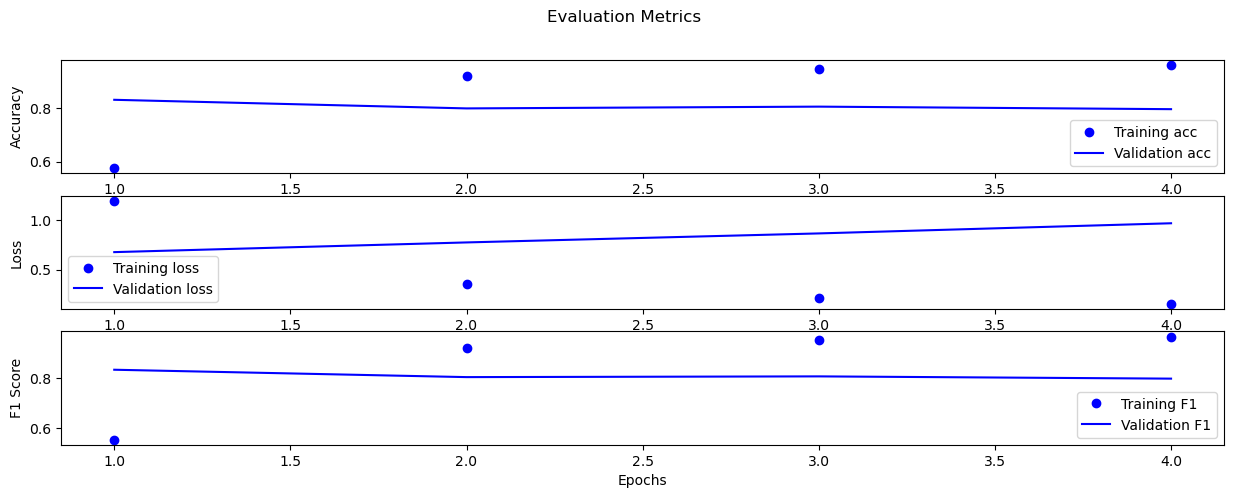

In [31]:
# define model architecture
model = Sequential([
    Dense(2048, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec)

Epoch 1/100
47/47 [==============================] - 4s 63ms/step - loss: 3.0880 - accuracy: 0.5909 - f1_score: 0.5690 - val_loss: 1.7420 - val_accuracy: 0.8029 - val_f1_score: 0.7991
Epoch 2/100
47/47 [==============================] - 2s 48ms/step - loss: 1.1558 - accuracy: 0.9000 - f1_score: 0.8996 - val_loss: 1.5256 - val_accuracy: 0.6943 - val_f1_score: 0.6898
Epoch 3/100
47/47 [==============================] - 2s 49ms/step - loss: 0.8098 - accuracy: 0.9192 - f1_score: 0.9190 - val_loss: 1.1431 - val_accuracy: 0.8171 - val_f1_score: 0.8178
Epoch 4/100
47/47 [==============================] - 2s 49ms/step - loss: 0.6570 - accuracy: 0.9257 - f1_score: 0.9256 - val_loss: 0.9875 - val_accuracy: 0.8286 - val_f1_score: 0.8290
Epoch 5/100
47/47 [==============================] - 2s 51ms/step - loss: 0.5718 - accuracy: 0.9343 - f1_score: 0.9341 - val_loss: 0.9386 - val_accuracy: 0.8181 - val_f1_score: 0.8191
Epoch 6/100
47/47 [==============================] - 2s 53ms/step - loss: 0.5040

'Internal validation accuracy: 81.81%'

'Internal validation F1 score: 0.8162'

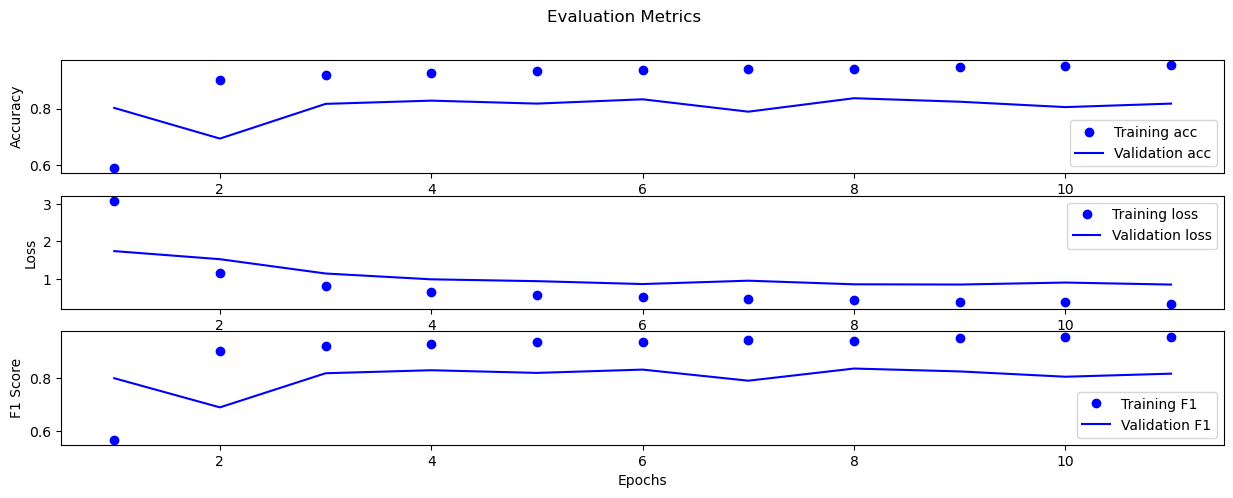

In [32]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec)

Epoch 1/100
47/47 [==============================] - 3s 42ms/step - loss: 1.5990 - accuracy: 0.7166 - f1_score: 0.7114 - val_loss: 1.2027 - val_accuracy: 0.8410 - val_f1_score: 0.8413
Epoch 2/100
47/47 [==============================] - 1s 29ms/step - loss: 0.8160 - accuracy: 0.9255 - f1_score: 0.9254 - val_loss: 1.1295 - val_accuracy: 0.8086 - val_f1_score: 0.8113
Epoch 3/100
47/47 [==============================] - 1s 27ms/step - loss: 0.6397 - accuracy: 0.9392 - f1_score: 0.9390 - val_loss: 0.9681 - val_accuracy: 0.8505 - val_f1_score: 0.8509
Epoch 4/100
47/47 [==============================] - 1s 27ms/step - loss: 0.5395 - accuracy: 0.9466 - f1_score: 0.9465 - val_loss: 0.9298 - val_accuracy: 0.8486 - val_f1_score: 0.8493
Epoch 5/100
47/47 [==============================] - 1s 28ms/step - loss: 0.4805 - accuracy: 0.9506 - f1_score: 0.9505 - val_loss: 0.9624 - val_accuracy: 0.8114 - val_f1_score: 0.8085
Epoch 6/100
47/47 [==============================] - 1s 29ms/step - loss: 0.4370

'Internal validation accuracy: 83.81%'

'Internal validation F1 score: 0.8369'

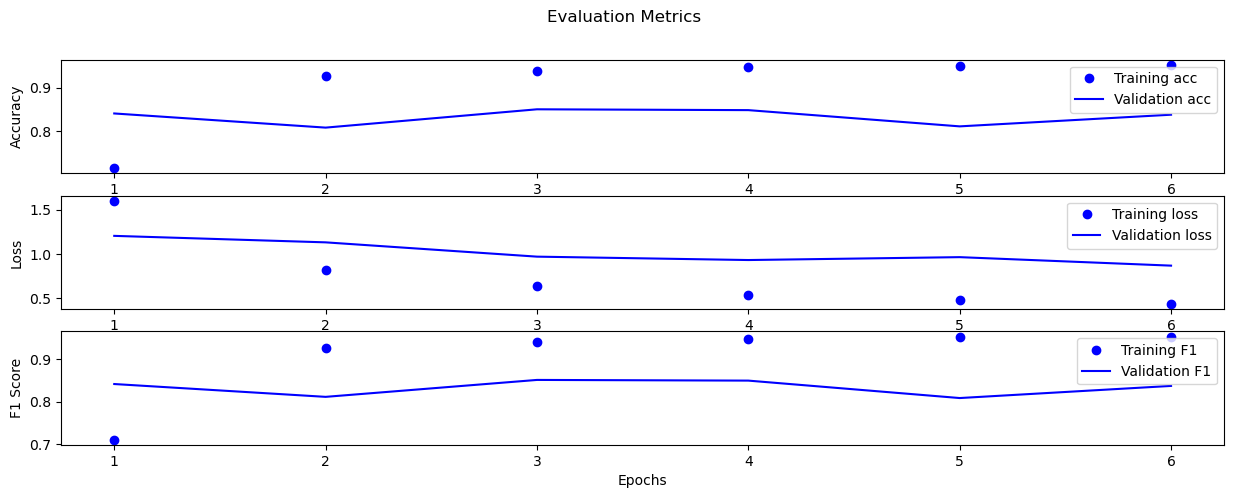

In [34]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec)

### Embeddings

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 48, 8)             384       
                                                                 
 flatten_8 (Flatten)         (None, 384)               0         
                                                                 
 dense_113 (Dense)           (None, 7)                 2695      
                                                                 
Total params: 3,079
Trainable params: 3,079
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [==============================] - 7s 138ms/step - loss: 1.7866 - accuracy: 0.2980 - f1_score: 0.1499 - val_loss: 1.8477 - val_accuracy: 0.2467 - val_f1_score: 0.0976
Epoch 2/100
47/47 [==============================] - 4s 81ms/step - loss: 1.7371 - accuracy: 0.3272 - f1_score: 0.2049 - val_loss:

'Internal validation accuracy: 63.52%'

'Internal validation F1 score: 0.6386'

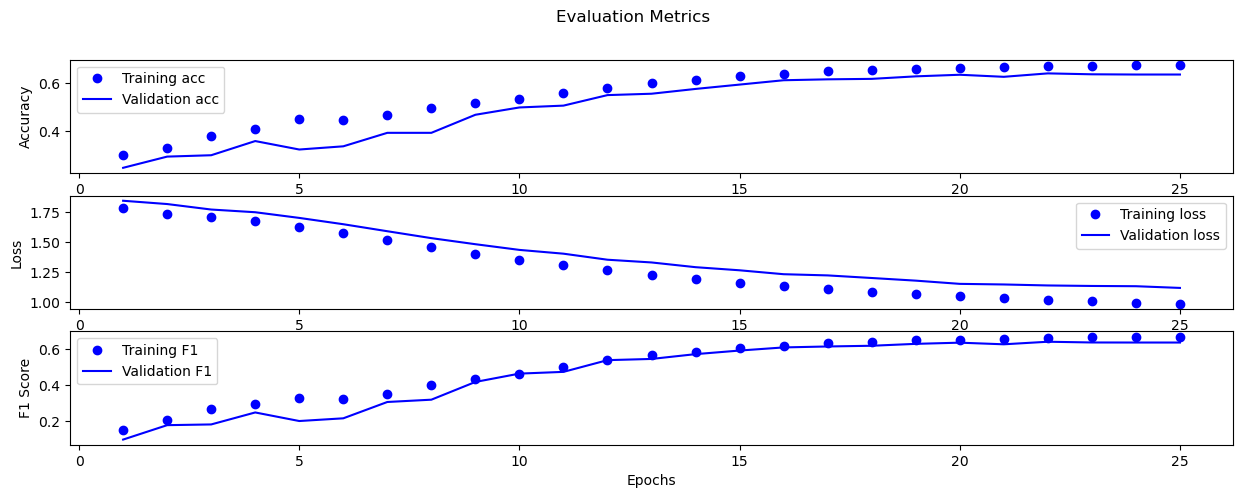

In [48]:
# define model architecture
model = Sequential([
    Embedding(48, 8, input_shape = (48, )),
    Flatten(),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 48, 8)             384       
                                                                 
 flatten_9 (Flatten)         (None, 384)               0         
                                                                 
 dense_114 (Dense)           (None, 8)                 3080      
                                                                 
 dense_115 (Dense)           (None, 7)                 63        
                                                                 
Total params: 3,527
Trainable params: 3,527
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [==============================] - 8s 143ms/step - loss: 1.8206 - accuracy: 0.2874 - f1_score: 0.2016 - val_loss: 1.9164 - val_accuracy: 0.2467 - val_f1_score: 0.097

'Internal validation accuracy: 55.9%'

'Internal validation F1 score: 0.5357'

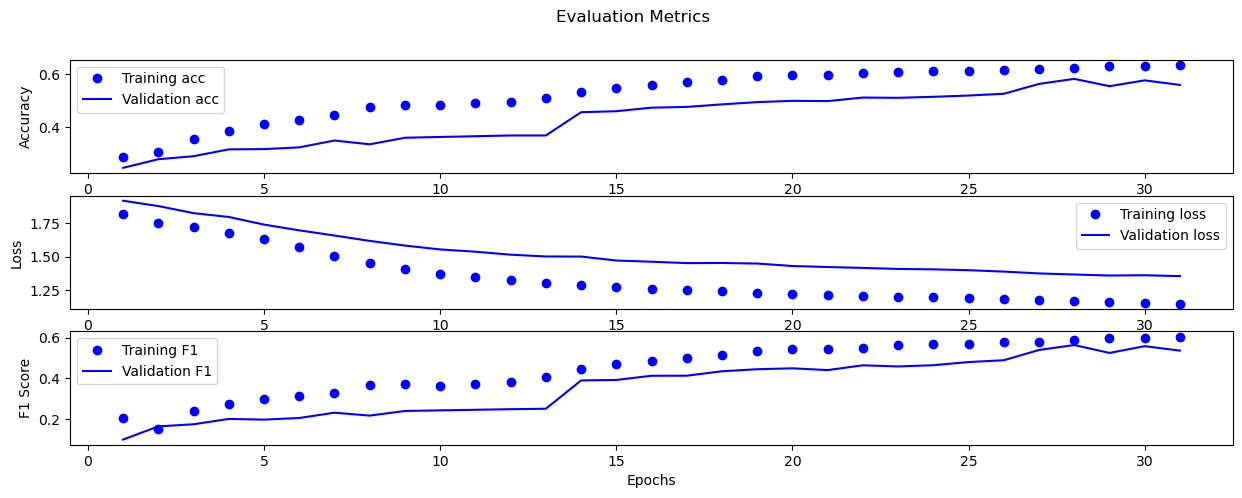

In [49]:
# define model architecture
model = Sequential([
    Embedding(48, 8, input_shape = (48, )),
    Flatten(),
    Dense(8, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 48, 64)            3072      
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_81 (Dense)            (None, 128)               393344    
                                                                 
 dense_82 (Dense)            (None, 64)                8256      
                                                                 
 dense_83 (Dense)            (None, 7)                 455       
                                                                 
Total params: 405,127
Trainable params: 405,127
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [============================

'Internal validation accuracy: 61.62%'

'Internal validation F1 score: 0.6118'

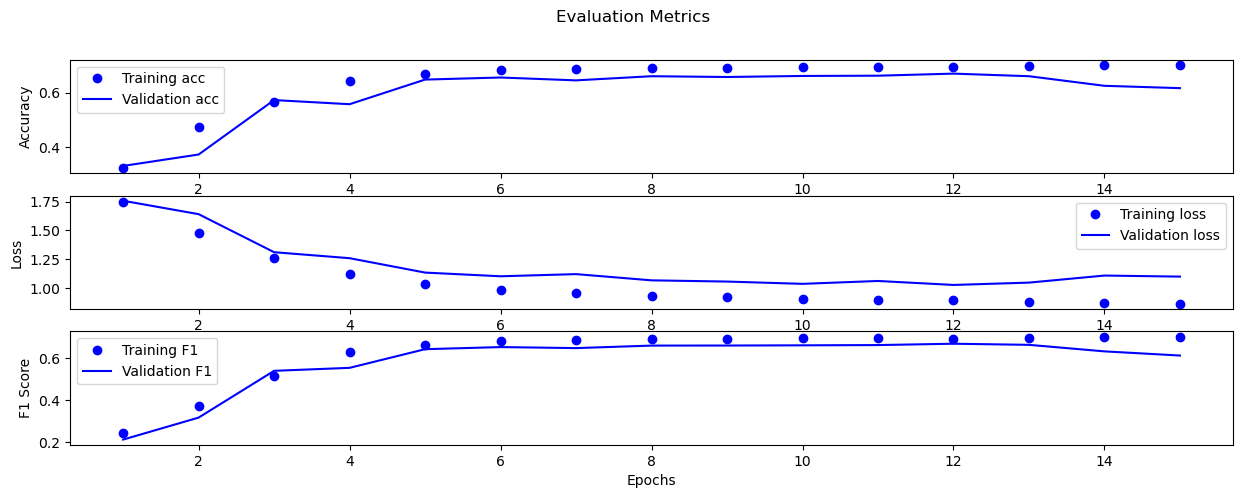

In [38]:
# define model architecture
model = Sequential([
    Embedding(48, 64, input_shape = (48, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 48, 128)           6144      
                                                                 
 flatten_4 (Flatten)         (None, 6144)              0         
                                                                 
 dense_90 (Dense)            (None, 128)               786560    
                                                                 
 dense_91 (Dense)            (None, 64)                8256      
                                                                 
 dense_92 (Dense)            (None, 7)                 455       
                                                                 
Total params: 801,415
Trainable params: 801,415
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [============================

'Internal validation accuracy: 65.43%'

'Internal validation F1 score: 0.6535'

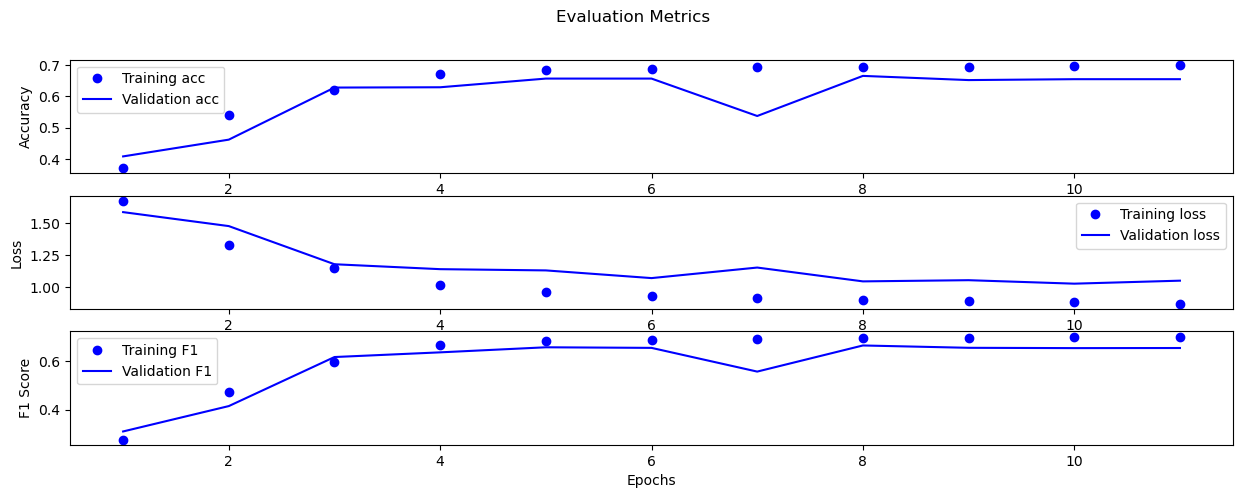

In [41]:
# define model architecture
model = Sequential([
    Embedding(48, 128, input_shape = (48, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 48, 256)           12288     
                                                                 
 flatten_5 (Flatten)         (None, 12288)             0         
                                                                 
 dense_93 (Dense)            (None, 256)               3145984   
                                                                 
 dense_94 (Dense)            (None, 128)               32896     
                                                                 
 dense_95 (Dense)            (None, 64)                8256      
                                                                 
 dense_96 (Dense)            (None, 7)                 455       
                                                                 
Total params: 3,199,879
Trainable params: 3,199,879
N

'Internal validation accuracy: 57.62%'

'Internal validation F1 score: 0.5631'

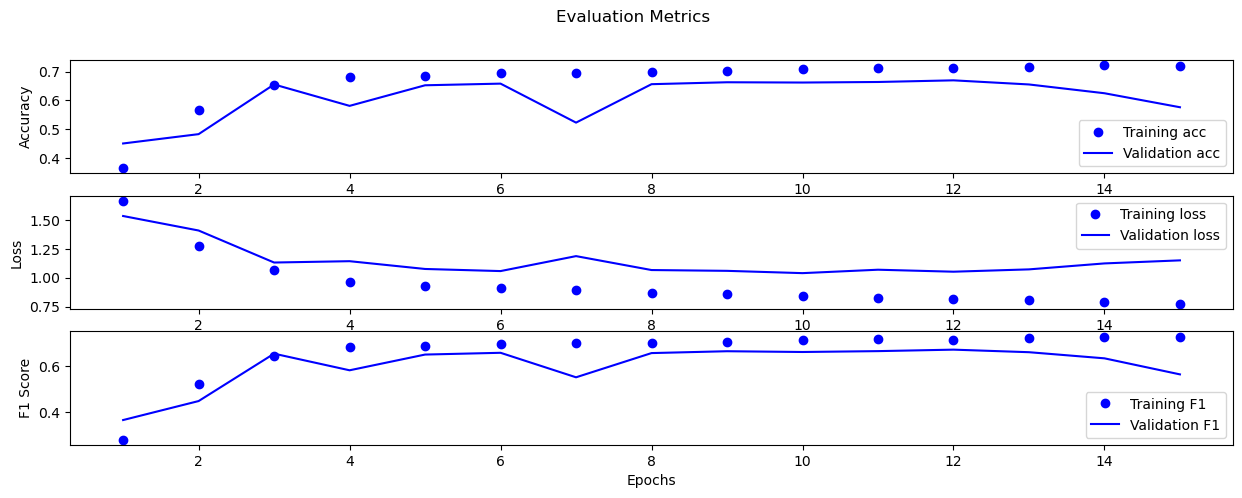

In [42]:
# define model architecture
model = Sequential([
    Embedding(48, 256, input_shape = (48, )),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 48, 1024)          49152     
                                                                 
 flatten_7 (Flatten)         (None, 49152)             0         
                                                                 
 dense_101 (Dense)           (None, 512)               25166336  
                                                                 
 dense_102 (Dense)           (None, 256)               131328    
                                                                 
 dense_103 (Dense)           (None, 128)               32896     
                                                                 
 dense_104 (Dense)           (None, 64)                8256      
                                                                 
 dense_105 (Dense)           (None, 7)               

'Internal validation accuracy: 55.43%'

'Internal validation F1 score: 0.5502'

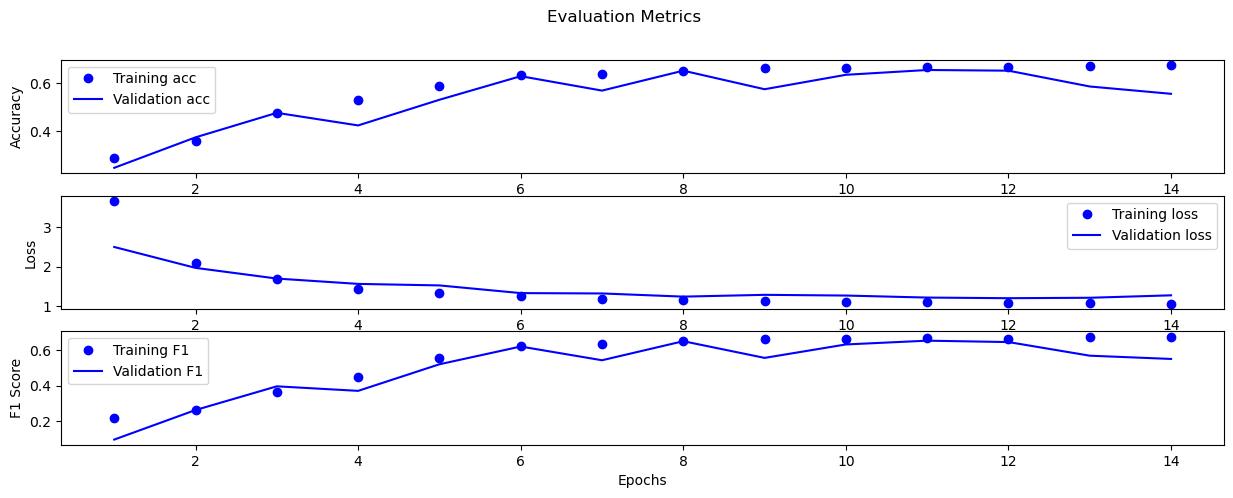

In [44]:
# define model hyperparameters
PENALTY = 0.005

# define model architecture
model = Sequential([
    Embedding(48, 1024, input_shape = (48, )),
    Flatten(),
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 4723, 64)          302272    
                                                                 
 flatten_2 (Flatten)         (None, 302272)            0         
                                                                 
 dense_84 (Dense)            (None, 128)               38690944  
                                                                 
 dense_85 (Dense)            (None, 64)                8256      
                                                                 
 dense_86 (Dense)            (None, 7)                 455       
                                                                 
Total params: 39,001,927
Trainable params: 39,001,927
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [======================

'Internal validation accuracy: 22.19%'

'Internal validation F1 score: 0.0806'

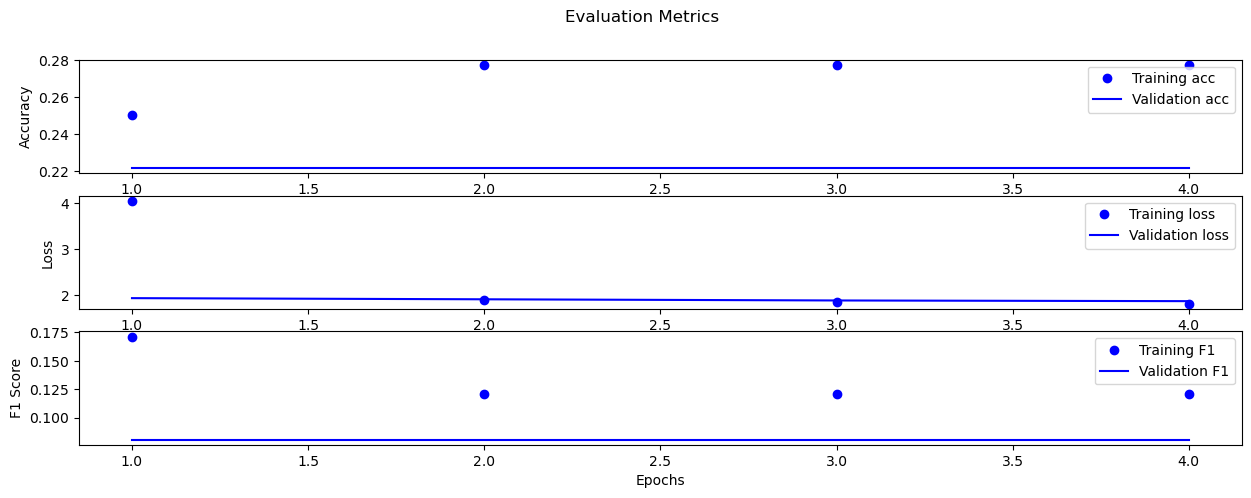

In [39]:
# define model architecture
model = Sequential([
    Embedding(4723, 64, input_shape = (4723, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 4723, 64)          302272    
                                                                 
 flatten_3 (Flatten)         (None, 302272)            0         
                                                                 
 dense_87 (Dense)            (None, 128)               38690944  
                                                                 
 dense_88 (Dense)            (None, 64)                8256      
                                                                 
 dense_89 (Dense)            (None, 7)                 455       
                                                                 
Total params: 39,001,927
Trainable params: 39,001,927
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [======================

'Internal validation accuracy: 24.67%'

'Internal validation F1 score: 0.0976'

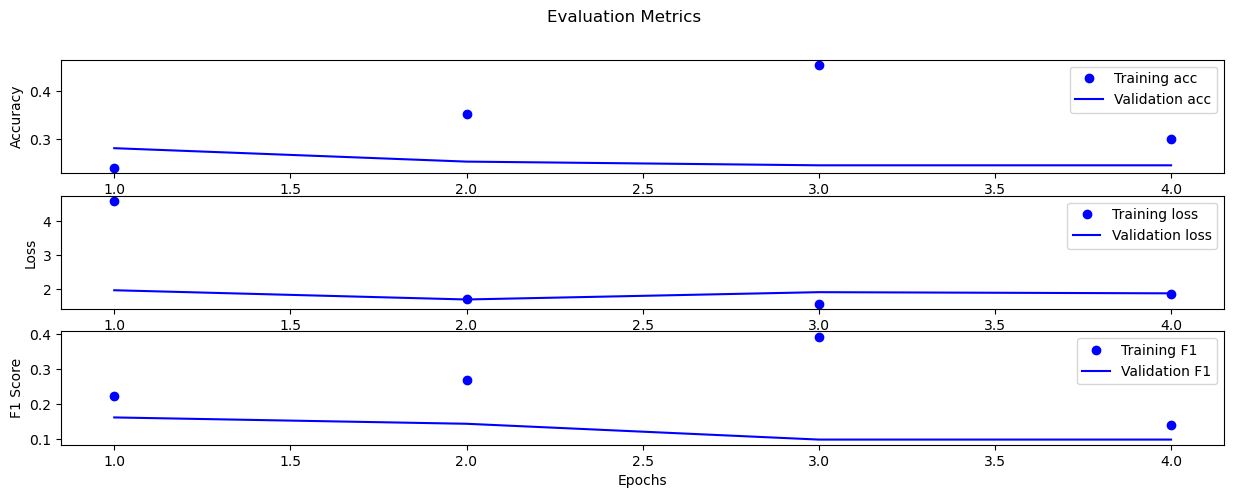

In [40]:
# define model architecture
model = Sequential([
    Embedding(4723, 64, input_shape = (4723, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec)

### RNNs

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 48, 8)             384       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                1312      
                                                                 
 dense_112 (Dense)           (None, 7)                 231       
                                                                 
Total params: 1,927
Trainable params: 1,927
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [==============================] - 55s 1s/step - loss: 1.7392 - accuracy: 0.3358 - f1_score: 0.2775 - val_loss: 1.6861 - val_accuracy: 0.3752 - val_f1_score: 0.2992
Epoch 2/100
47/47 [==============================] - 51s 1s/step - loss: 1.5591 - accuracy: 0.4503 - f1_score: 0.3803 - val_loss: 1.

'Internal validation accuracy: 48.19%'

'Internal validation F1 score: 0.423'

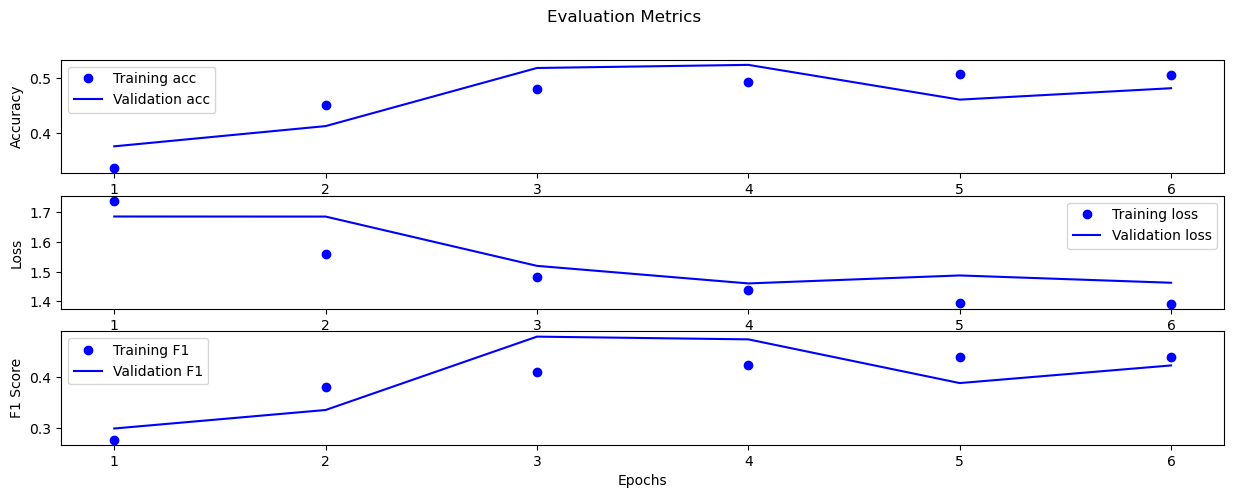

In [47]:
# define model architecture
model = Sequential([
    Embedding(48, 8, input_shape = (48, )),
    SimpleRNN(32),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 48, 8)             384       
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 48, 32)            1312      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 48, 32)            2080      
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 7)                 231       
                                                                 
Total params: 6,087
Trainable params: 6,087
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [==============================] -

'Internal validation accuracy: 63.62%'

'Internal validation F1 score: 0.6292'

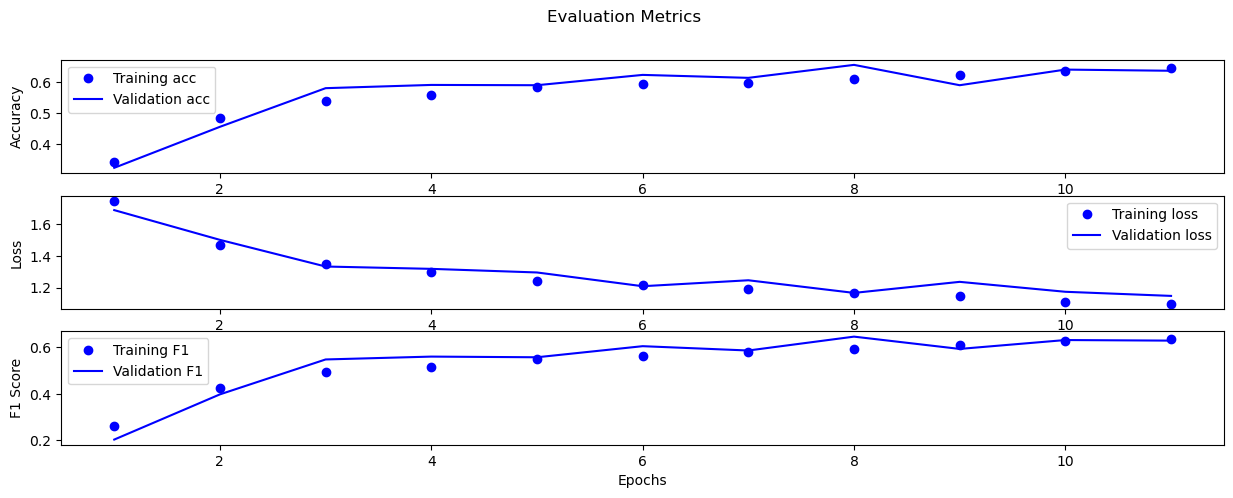

In [12]:
# define model architecture
model = Sequential([
    Embedding(48, 8, input_shape = (48, )),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 48, 16)            768       
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 48, 32)            1568      
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 48, 32)            2080      
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 48, 32)            2080      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 7)                 231       
                                                                 
Total params: 8,807
Trainable params: 8,807
Non-traina

'Internal validation accuracy: 61.24%'

'Internal validation F1 score: 0.6093'

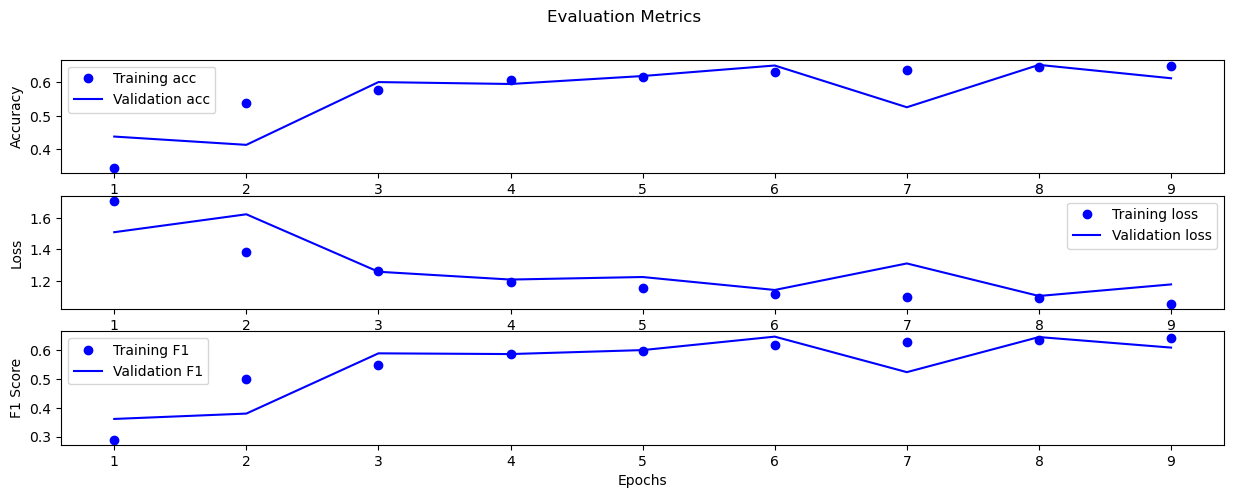

In [13]:
# define model architecture
model = Sequential([
    Embedding(48, 16, input_shape = (48, )),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 48, 16)            768       
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 48, 32)            1568      
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 48, 32)            2080      
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 48, 32)            2080      
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 48, 32)            2080      
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense_5 (Dense)             (None, 64)               

'Internal validation accuracy: 66.19%'

'Internal validation F1 score: 0.6588'

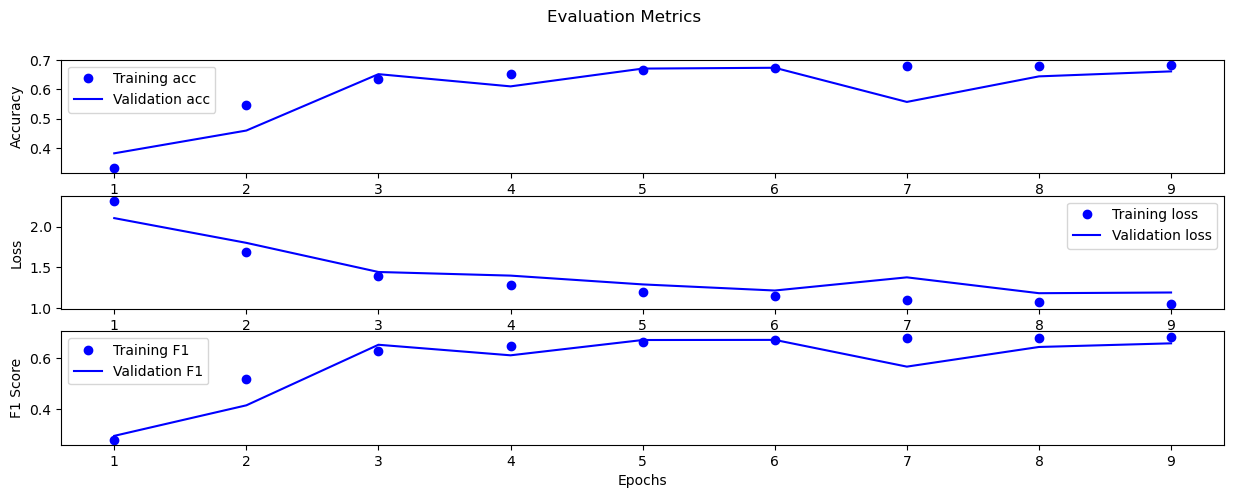

In [14]:
# define penalty hyperparameter
PENALTY = 0.005

# define model architecture
model = Sequential([
    Embedding(48, 16, input_shape = (48, )),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    Flatten(),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(16, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 48, 16)            768       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                528       
                                                                 
 dense_109 (Dense)           (None, 128)               2176      
                                                                 
 dense_110 (Dense)           (None, 64)                8256      
                                                                 
 dense_111 (Dense)           (None, 7)                 455       
                                                                 
Total params: 12,183
Trainable params: 12,183
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [==============================

'Internal validation accuracy: 44.67%'

'Internal validation F1 score: 0.3827'

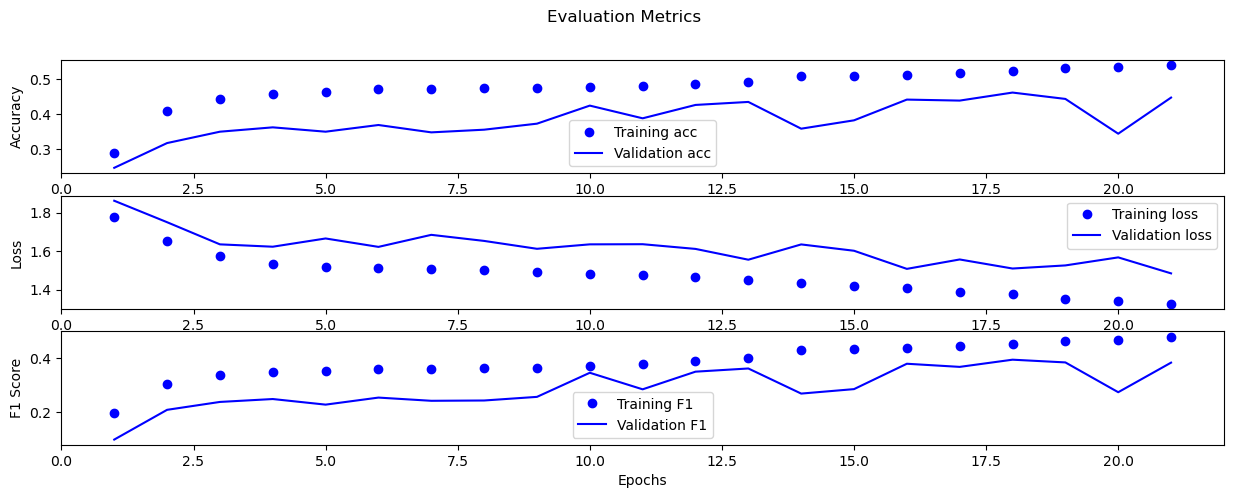

In [46]:
# define model architecture
model = Sequential([
    Embedding(48, 16, input_shape = (48, )),
    SimpleRNN(16),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 48, 64)            3072      
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                3104      
                                                                 
 dense_106 (Dense)           (None, 128)               4224      
                                                                 
 dense_107 (Dense)           (None, 64)                8256      
                                                                 
 dense_108 (Dense)           (None, 7)                 455       
                                                                 
Total params: 19,111
Trainable params: 19,111
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [==============================

'Internal validation accuracy: 35.52%'

'Internal validation F1 score: 0.244'

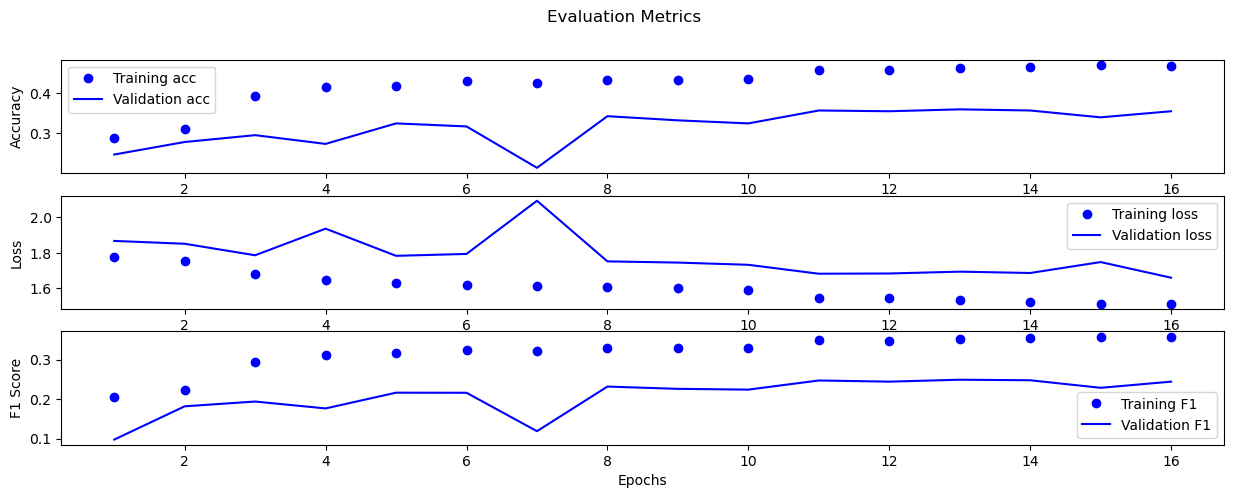

In [45]:
# define model architecture
model = Sequential([
    Embedding(48, 64, input_shape = (48, )),
    SimpleRNN(32),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

In [9]:
# define model architecture
model = Sequential([
    Embedding(4723, 8, input_shape = (4723, )),
    SimpleRNN(16),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4723, 8)           37784     
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                400       
                                                                 
 dense (Dense)               (None, 7)                 119       
                                                                 
Total params: 38,303
Trainable params: 38,303
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


In [9]:
# define model architecture
model = Sequential([
    Embedding(4723, 8, input_shape = (4723, )),
    SimpleRNN(16),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4723, 8)           37784     
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                400       
                                                                 
 dense (Dense)               (None, 7)                 119       
                                                                 
Total params: 38,303
Trainable params: 38,303
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
